# Random Forest Classifer for News Data

##IDEA:
Implement a RFC for our news dataset, however there are initally a major problem

- Our feature variables are text and RFC only can use floating point numbers for classification

## Solution

Use gloVe word embeddings to embed every word in the title and the description, then use an aggregatae method to hopefully collate enough information to use prediction. In the code below we have simply averaged the word embeddings.

In [71]:
import pandas as pd
import numpy as np
import csv

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from tensorflow.keras.preprocessing.text import Tokenizer


data = []
words = []



with open('train.csv') as f:
  reader = csv.reader(f)
  next(reader)
  for row in reader:
    # Tokenisation of words for embedding creation

    t = int(row[0])
    title = row[1].split()
    title = [t.lower() for t in title]
    description = row[2].split()
    description = [d.lower() for d in description]
    try:
      words.extend(t.lower() for t in title)
    except:
      pass


    data.append([t,title,description])




In [69]:
# create the dict and tokenize the words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(words)

In [70]:
# Creates a dictionary that maps each unique word to an idx.

print("Number of unique words in dictionary=",len(tokenizer.word_index))
print("Dictionary is = ", tokenizer.word_index)

Number of unique words in dictionary= 36752
Dictionary is =  {'to': 1, 'in': 2, '39': 3, 'for': 4, 'on': 5, 'of': 6, 's': 7, 'ap': 8, 'the': 9, 'b': 10, 'gt': 11, 'lt': 12, 'a': 13, 'reuters': 14, 'at': 15, 'us': 16, 'with': 17, 'new': 18, 'as': 19, 'up': 20, 'and': 21, 'oil': 22, 'says': 23, 'over': 24, 'microsoft': 25, 'u': 26, 'iraq': 27, 'by': 28, 'is': 29, '1': 30, 'from': 31, 'after': 32, 'afp': 33, 'out': 34, 'no': 35, '2': 36, 'deal': 37, 'china': 38, 'stocks': 39, 'more': 40, 'profit': 41, 'may': 42, 'be': 43, 'win': 44, 'update': 45, 'not': 46, 'talks': 47, 'bush': 48, 'game': 49, 'wins': 50, 'it': 51, 'world': 52, 'back': 53, 'first': 54, '3': 55, 'sales': 56, 'report': 57, 'prices': 58, 'off': 59, 'ibm': 60, 'security': 61, 'will': 62, 'open': 63, 'down': 64, 'eu': 65, 't': 66, 'google': 67, 'into': 68, 'two': 69, 'com': 70, 'against': 71, 'set': 72, 'top': 73, 'un': 74, 'gets': 75, 'japan': 76, 'india': 77, 'court': 78, 'record': 79, 'bid': 80, 'rise': 81, '4': 82, 'its': 

In [60]:
# Download and unzip the pre-trained gloVe word embeddings

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-04-15 08:45:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-15 08:45:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-15 08:45:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [62]:
# Create a embedding_matrix, which has for each word in our word_index a corresponding
# Embedding of size 50.

def embedding_for_vocab(filepath, word_index,
                        embedding_dim):
    vocab_size = len(word_index) + 1

    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix_vocab


# matrix for vocab: word_index
embedding_dim = 50
embedding_matrix_vocab = embedding_for_vocab(
    'glove.6B.50d.txt', tokenizer.word_index,
  embedding_dim)

print("Dense vector for first word is => ",
      embedding_matrix_vocab[1])

Dense vector for first word is =>  [ 0.68046999 -0.039263    0.30186    -0.17792     0.42962     0.032246
 -0.41376001  0.13228001 -0.29846999 -0.085253    0.17117999  0.22419
 -0.10046    -0.43652999  0.33418     0.67846     0.057204   -0.34448001
 -0.42785001 -0.43274999  0.55962998  0.10032     0.18677001 -0.26853999
  0.037334   -2.09319997  0.22171    -0.39868     0.20912001 -0.55725002
  3.88260007  0.47466001 -0.95657998 -0.37788001  0.20869    -0.32752001
  0.12751     0.088359    0.16350999 -0.21634001 -0.094375    0.018324
  0.21048    -0.03088    -0.19722     0.082279   -0.09434    -0.073297
 -0.064699   -0.26043999]


In [77]:
# For a list of strings gather their respective word embeddings then average them

def get_list_embedding(list, embedding_matrix, vocab_idx):

  title_embedding = []

  for word in list:
    if word in vocab_idx:

      idx = vocab_idx[word]
      embedding = embedding_matrix[idx]
      title_embedding.append(embedding)


  return np.mean(title_embedding)


get_list_embedding(["the","lazy","dog"], embedding_matrix_vocab, tokenizer.word_index)

for d in data:
  d[1] = get_list_embedding(d[1], embedding_matrix_vocab, tokenizer.word_index)
  d[2] = get_list_embedding(d[2],embedding_matrix_vocab, tokenizer.word_index)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [95]:
# Data => Train, test split

data = pd.DataFrame(data, columns = ("Target","Title","Description"))

print(data.shape)
data = data.dropna()


 X = data.drop("Target", axis = 1)
 y = data["Target"]

 # Train split

 X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)


(119890, 3)


In [92]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [102]:
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.8662106931353741


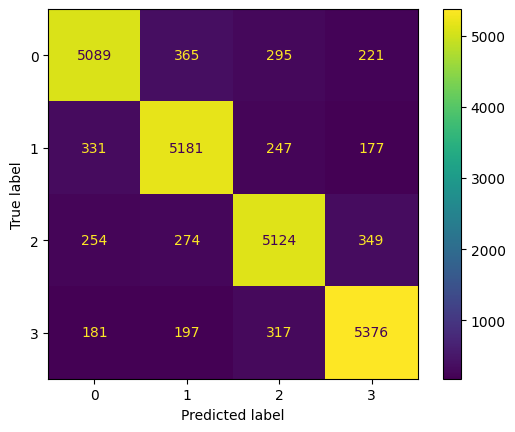

In [98]:
cm = confusion_matrix(y_test,y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

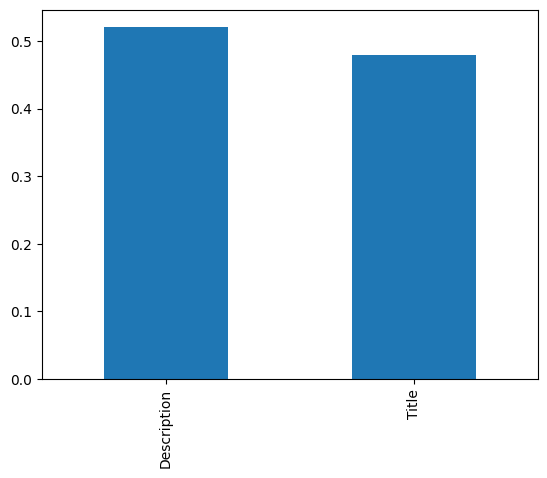

In [104]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();